<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-общей-информации-и-первичная-подготовка-данных" data-toc-modified-id="Изучение-общей-информации-и-первичная-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение общей информации и первичная подготовка данных</a></span></li><li><span><a href="#Подготовка-текста-для-моделирования" data-toc-modified-id="Подготовка-текста-для-моделирования-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка текста для моделирования</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Moдель-LogisticRegression" data-toc-modified-id="Moдель-LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Moдель LogisticRegression</a></span></li><li><span><a href="#Moдель-RandomForestClassifier" data-toc-modified-id="Moдель-RandomForestClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Moдель RandomForestClassifier</a></span></li><li><span><a href="#Moдель-SGDClassifier" data-toc-modified-id="Moдель-SGDClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Moдель SGDClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li>

<h1><center>Разработка модели МО для классификации комментариев</center></h1>

# Описание исследования

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  


# Цель проекта

С помощью машинного обучения необходимо классифицировать комментарии на позитивные и негативные.

# Задачи исследования

Разработать модель машинного обучения для классификации комментариев на позитивные и негативные на основе набора данных с разметкой о токсичности правок.

Для этого нужно:

1. Загрузить и подготовить данные.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.


Критерием выбора лучшей модели является значение метрики качества *F1* не меньше 0.75.


# Исходные данные

В наличии csv-файл `toxic_comments.csv`.

Название и описание столбцов:
- *text* - текст комментария.
- *toxic* - целевой признак: 1 - негативный комментарий, 0 - положительный.

## Изучение общей информации и первичная подготовка данных

In [ ]:
# импорт библиотек
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# загружаем инструменты для работы с текстом
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from pymystem3 import Mystem
import re
from tqdm import notebook
from tqdm.notebook import tqdm

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# загружаем нужные метрики
from sklearn.metrics import f1_score, confusion_matrix

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# настройка графиков

# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'axes.titleweight': 'bold',
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

In [ ]:
# задание константных значений
RANDOM_STATE = 42
TEST_SIZE = 0.25

Для начала считаем исходный csv-файл и сохраним его в переменной df. Затем сделаем предварительный просмотр данных методом sample(10) и с помощью метода info() узнаем основные характеристики исходного датасета.

In [ ]:
# сохранение данных в переменной df, если путь неверный выдать сообщение об ошибке
path = '/datasets/toxic_comments.csv'

if os.path.exists(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
else:
    print('Something is wrong')

In [ ]:
# просмотр 10 случайных строк датафрейма
df.sample(10)

,text,toxic
126544,False accusations of vandalism \n\nI have a ve...,0
70824,"Moving pages \n\nHi, could you stop moving pag...",0
123512,Hunter...\nI luv your page im jealous why is i...,0
99405,Give it and other links a try in See also that...,0
86953,"""Untitled==\nThe article on Mastix is awful, b...",0
155851,"Thanks. If you wouldn't mind, please self-reve...",0
65603,Article should be moved to Mark Basseley Youss...,0
24314,If you thought of a better one - offer it.,0
57783,"""\n\nOrphaned fair use image (Image:Worldcup98...",0
2308,"""\n\n Deletion probable \n\nI'm not aware that...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<font size="4"><b>Выводы по первоначальному обзору данных в датафрейма df</b></font>

- Названия столбцов менять не надо.
- В данных 159292 строчек и 2 столбца.
- Пропусков нет.
- В данных присутствуют комментарии, написанные верхним регистром. Нужно привести данные в столбце 'text' к нижнему регистру и проверить датафрейм на дубликаты.
- Тип данных в столбце `toxic` можно преобразовывать в булевский, но пока оставим как есть.

Проверим есть ли дисбаланс классов в целевом признаке. Для наглядности визуализируем результат с помощью горизонтальной столбчатой диаграммы.

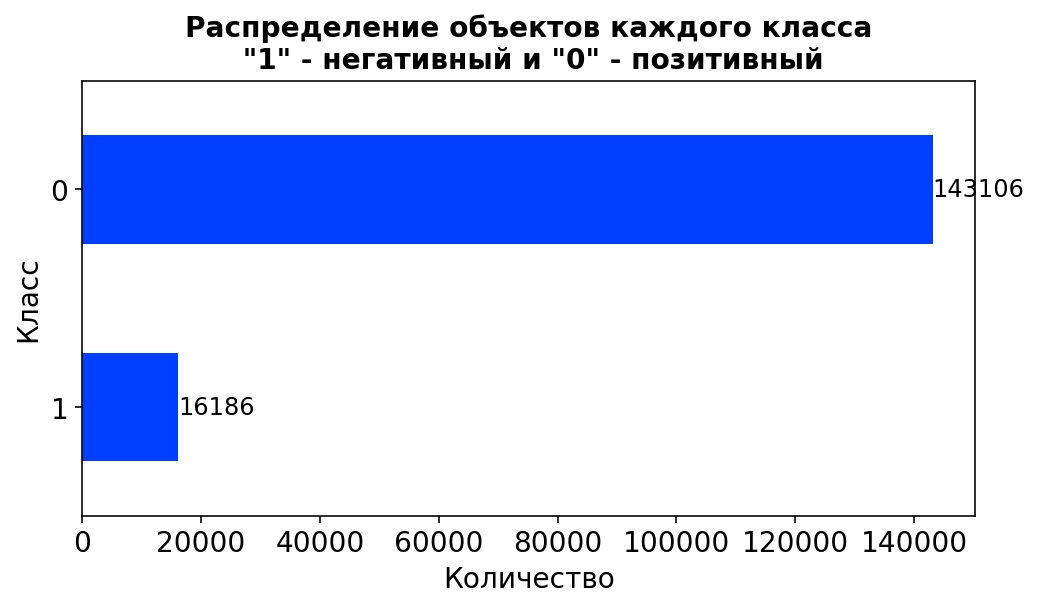

In [ ]:
# построение графика
ax = df['toxic'] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='toxic', kind='barh',
              legend=False, figsize=(8, 4))

plt.title('Распределение объектов каждого класса\n "1" - негативный и "0" - позитивный')
plt.ylabel('Класс')
plt.xlabel('Количество')

# добавление меток для каждого столбца
for index, value in enumerate(df['toxic'].value_counts(ascending=True)):
    ax.text(value, index, str(value), ha='left', va='center', fontsize=12)

plt.show()

Налицо дисбаланс классов: позитивных отзывов (класс "0") в 8.8 раз больше, чем токсичных (класс "1"). Необходимо будет это учесть при разделении датасета на обучающую и тестовую выборки.

Как было выявлено при первоначальном обзоре данных в столбце `text` присутствуют комментарии, написанные верхним регистром. Приведём всё к нижнему регистру и проверим наличие строк-дубликат с помощью комбинации методов duplicated() и sum().

In [ ]:
# приведение данных в столбце text к нижнему регистру
df['text'] = df['text'].str.lower()

# проверка наличия дублирующихся строчек
df.duplicated().sum()

45

Как выяснилось в результате проверки, в данных есть 45 дублирующихся строчек. Удалим их с помощью drop_duplicates().

In [ ]:
# удаление строк-дубликат в датафреймах df и data методом drop_duplicates()
df.drop_duplicates(inplace=True)

# проверка удаления дублирующихся строчек
df.duplicated().sum()

0

<font size="4"><b>Выводы по этапу обзора и первичной обработки данных:</b></font>

- Было выявлено, что присутствует дисбаланс классов в целевом признаке: позитивных отзывов (класс "0") в 8.8 раз больше, чем токсичных (класс "1").
- После приведения данных в столбце `text` к нижнему регистру, было обнаружено 45 дублирующихся строчек. Они были удалены.

## Подготовка текста для моделирования

Для того, чтобы использовать текст в моделировании, необходимо провести его предобработку и затем перевести в векторный формат.

Предобработка текста включает следующие этапы:
- очищение текста от неинформативных символов;
- токенизация текста, т.е. его разделение на слова;
- лемматизация, т.е. приведение к начальной словарной форме.

Напишем функции для предобработки текста.
Лемматизацию сделаем с помощью WordNetLemmatizer библиотеки NLTK. В качестве второго аргумента lemmatize() укажем тег `pos='v'`, т.е. `verb`, т.к. больше неточностей возникает в лемматизации глаголов.

In [ ]:
# создание экземпляра WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()

def preprocessing(text):
    '''
    Функция, которая очищает текст от ненужных символов,
    производит токенизацию текста с помощью метода split(),
    затем лемматизацию с помощью lemmatize()
    и сшивку получившихся слов методом join()
    '''
    clean = re.sub(r'[^a-zA-Z ]', ' ', text)
    words = clean.split()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(words)

In [ ]:
# запуск прогресс-бара

tqdm.pandas()
df['prepared'] = df['text'].progress_apply(preprocessing)

  0%|          | 0/159247 [00:00<?, ?it/s]

Посмотрим на результат применения функций токенизации, лемматизации и очистки от неинформативных символов. С помощью метода sample() сравним исходный и подготовленный текст.

In [ ]:
df.sample(10)

,text,toxic,prepared
67410,""")\n\ni see what you mean, this page convenien...",0,i see what you mean this page conveniently lea...
63535,bjerknes' site gives a long list of published ...,0,bjerknes site give a long list of publish refe...
41115,"""\nthank you for filing the rfc. please do not...",0,thank you for file the rfc please do not menti...
129524,"dear readers,\n\nmy last will is that my accou...",0,dear readers my last will be that my account s...
62444,"""hello, """"rhpitts1055""""\n\nwhere did you find ...",0,hello rhpitts where do you find the date for h...
90806,my apologies for removing w/o permission. i'm ...,0,my apologies for remove w o permission i m do ...
17296,"""\n\n this is our one demand you can not get y...",0,this be our one demand you can not get your or...
15076,"""\nif fallout boy wouldn't mind my commenting ...",0,if fallout boy wouldn t mind my comment on the...
7719,europeans are the racist trolls. \n\nswedes ar...,1,europeans be the racist troll swedes be anti s...
3092,this might be a better article if someone proc...,0,this might be a better article if someone proc...


Проверка показала, что
* все лишние символы (кавычки, числа, знаки препинания, переносы строк и т.п.) пропали;
* текст на первый взгляд достаточно хорошо лемматизировался, т.е. и в существительных слова во множественном числе приведены к единственному, и в глаголах пропали окончания времени и рода (-s, -ed, -ing), а неправильные приведены к первой форме (например, was -> be, wrote -> write и т.д.). Оставим этот вариант предобработки текста. В случае неудовлетворительного качества модели, вернемся к этому вопросу. Можно будет попробовать использовать "распознаватель" части речи для более точной лемматизации (nltk.pos_tag()).

Разделим данные на обучающую и тестовую выборку с учетом стратификации по целевому признаку.

In [ ]:
# сохранение входных признаков в переменной Х, а целевого в у
X = df['prepared']
y = df['toxic']

# задание константных значений
RANDOM_STATE = 42
TEST_SIZE = 0.1

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (143322,), тестовой выборки: (15925,)


Очистим от стоп-слов и создадим матрицу cо значениями TF-IDF по корпусу текстов.

In [ ]:
# загрузка списка стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size="4"><b>Выводы по этапу подготовки текста:</b></font>

- провели предобработку текста: очистили от неинформативных символов, токенизировали и лемматизировали.
- разделили данные на обучающую и тестовую выборку в соотношении train/test 3:1 с учетом стратификации по целевому признаку.
- создали корпусы текстов для обучающей и тестовой выборки,
- очистили их от стоп-слов,
- создали матрицу cо значениями TF-IDF по корпусу текстов.

## Обучение моделей

### Moдель LogisticRegression

Собрерём расчет TF-IDF и GridSearch в пайплайн. Применим функцию с пайплайном ко всем моделям.

In [ ]:
# создание пустого списка для добавления лучших метрик по всем лучшим моделям
f1_cv = []

def prep_model_pipe(model, params):
    '''
    Функция, которая создает матрицу признаков TF-IDF, производит подбор гиперпараметров и
    возвращает лучшую модель
    '''

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=50, stop_words=list(stopwords))),
        ('clf', model),
    ])

    gs = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=3,
        scoring='f1',
        n_jobs=-1
    )

    # запуск поискa  лучших гиперпараметров
    gs.fit(X_train, y_train)

    print('Параметры лучшей модели:\n\n', gs.best_estimator_)

    f1_cv.append(gs.best_score_)

    return gs.best_estimator_

In [ ]:
# словарь с параметрами для LogisticRegression
lr_params = {'clf__C': range(1, 15, 3)}

# инициализируем модель LogisticRegression
model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=200)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для LogisticRegression
model_lr = prep_model_pipe(model_lr, lr_params)

Параметры лучшей модели:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=50,
                                 stop_words=['just', 'my', "doesn't", "it's",
                                             'me', 'further', 'by', 'nor',
                                             'weren', 'do', 'during', 'am',
                                             "isn't", "you're", 'theirs',
                                             'hasn', 'as', 'can', 'over',
                                             'other', 'between', 'through', 's',
                                             'into', 'i', "that'll", 'couldn',
                                             'under', 'when', 'most', ...])),
                ('clf',
                 LogisticRegression(C=13, max_iter=200, random_state=42,
                                    solver='liblinear'))])


### Moдель RandomForestClassifier

In [ ]:
# словарь с параметрами для RandomForestClassifier
rfc_params = {'clf__n_estimators': [150],
               'clf__max_depth': [15, 20],
               'clf__min_samples_leaf': [8]}

# инициализируем модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для RandomForestClassifier
model_rfc = prep_model_pipe(rfc, rfc_params)

Параметры лучшей модели:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=50,
                                 stop_words=['just', 'my', "doesn't", "it's",
                                             'me', 'further', 'by', 'nor',
                                             'weren', 'do', 'during', 'am',
                                             "isn't", "you're", 'theirs',
                                             'hasn', 'as', 'can', 'over',
                                             'other', 'between', 'through', 's',
                                             'into', 'i', "that'll", 'couldn',
                                             'under', 'when', 'most', ...])),
                ('clf',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=8,
                                        n_estimators=150, random_state=42))])


### Moдель SGDClassifier

In [ ]:
# словарь с параметрами для SGDClassifier
sgd_params = {'clf__max_iter': [20],
              'clf__alpha': [0.00001, 0.0000001],
              'clf__penalty': ['l2', 'elasticnet']}

# инициализируем модель SGDClassifier
sgdc = SGDClassifier()

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для RandomForestClassifier
model_sgdc = prep_model_pipe(sgdc, sgd_params)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Conside

Параметры лучшей модели:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=50,
                                 stop_words=['just', 'my', "doesn't", "it's",
                                             'me', 'further', 'by', 'nor',
                                             'weren', 'do', 'during', 'am',
                                             "isn't", "you're", 'theirs',
                                             'hasn', 'as', 'can', 'over',
                                             'other', 'between', 'through', 's',
                                             'into', 'i', "that'll", 'couldn',
                                             'under', 'when', 'most', ...])),
                ('clf', SGDClassifier(alpha=1e-05, max_iter=20))])


## Тестирование

Соберем все метрики f1, оцененные на кросс-валидации по всем моделям в датафрейм.

In [ ]:
result = pd.DataFrame(
    {
    "Модель": ['LogisticRegression', 'RandomForestClassifier', 'SGDClassifier'],
    "f1 на cv": f1_cv
    }
)

result

,Модель,f1 на cv
0,LogisticRegression,0.764044
1,RandomForestClassifier,0.181460
2,SGDClassifier,0.758202


Модель логистической регрессии показала наилучшую метрику f1 на кросс-валидации равную 0.764. Модели LogisticRegression и SGDClassifier проходят по критерию значение метрики качества F1 не меньше 0.75. Т.к. в продакшн можно взять только одну модель, выберем логистическую регрессию, показавшую чуть лучшую метрику. Ее и будем использовать для получения предсказаний на тестовых данных.

In [ ]:
# получение прогнозных значений на тестовых данных
y_pred_lr = model_lr.predict(X_test)

# расчет F1 для модели LogisticRegression
f1_test = f1_score(y_test, y_pred_lr)

print(f"Метрика на тестовых данных F1: {f1_score(y_test, y_pred_lr):.2f}")

Метрика на тестовых данных F1: 0.77


F1 метрика на тестовых данных оказалась даже чуть лучше метрики на кросс-валидации и равна 0.77.

Построим матрицу ошибок и узнаем ошибки какого рода чаще совершает модель, для того чтобы понять в какую сторону еще можно улучшить модель.

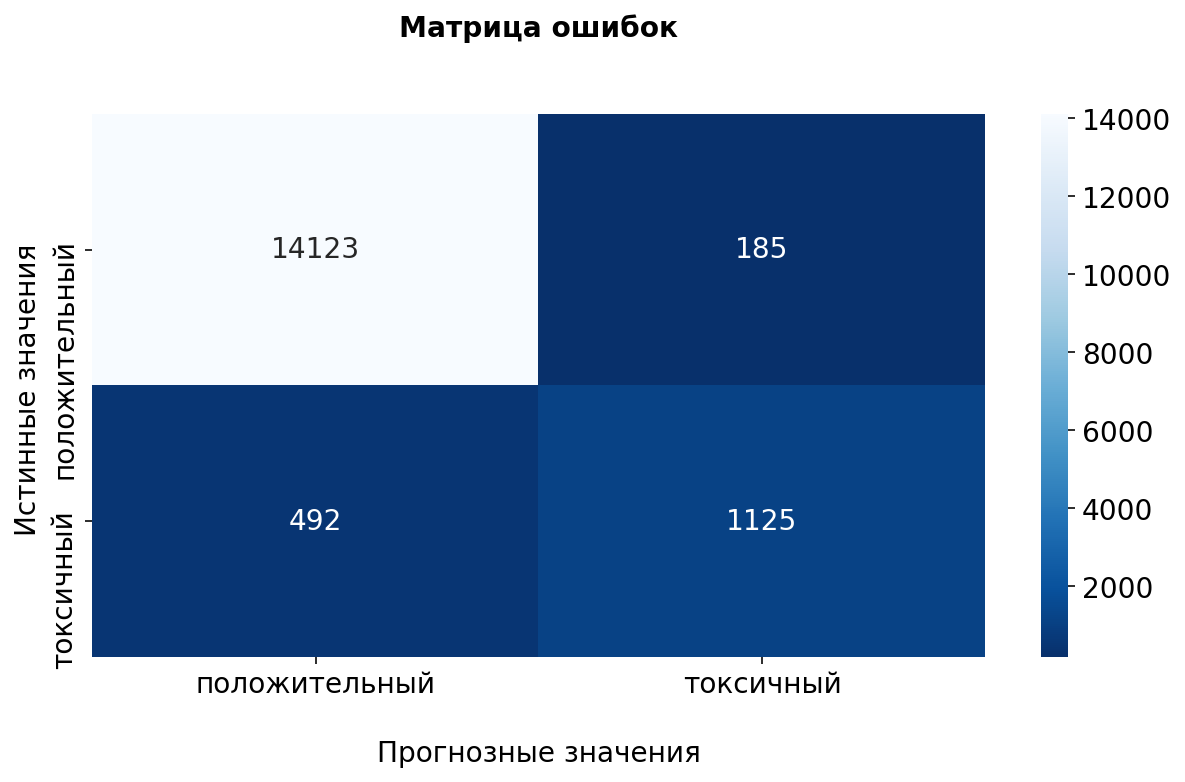

In [ ]:
# расчет матрицы ошибок
cm = confusion_matrix(y_test, y_pred_lr)

# визуализация матрицы ошибок с помощью тепловой карты
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(cm, annot=True, cmap='Blues_r', annot_kws={"size":14}, fmt=".0f")

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПрогнозные значения')
ax.set_ylabel('Истинные значения ')

ax.xaxis.set_ticklabels(['положительный', 'токсичный'])
ax.yaxis.set_ticklabels(['положительный', 'токсичный'])

plt.show()

Как видно из матрицы ошибок модель чаще совершает ошибки первого рода, т.е. классифицирует токсичные комментарии как положительные (492 случаев). И в 3 раза меньше ошибок 2го рода (185 случаев), т.е. классифицирует положительные комментарии как токсичные. Вероятно, это связано с дисбалансом классов. Т.к. положительных комментариев (класс "0") больше, то модель чаще ее присваивает, в том числе и ошибочно. Таким образом, зоной роста является работа над уменьшением влияния дисбаланса классов.

Проверим также метрику F1 на дамми модели.

In [ ]:
# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# расчет F1 для модели DummyClassifier
f1_dummy_test = f1_score(y_test, dummy_model_preds)
print(f'Метрика F1 на тестовой выборке дамми-модели:  {f1_dummy_test:.2f}')

Метрика F1 на тестовой выборке дамми-модели:  0.17


Метрика на дамми модели оказалась существенно хуже выбранной модели.

## Выводы

В ходе данного проекта были изучены данные интернет-магазина «Викишоп», относящиеся к работе нового сервиса, в котором пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Задачей проекта была разработка модели машинного обучения для поиска токсичных комментариев, которые необходимо отправлять на модерацию.

В ходе **этапа обзора и первичной обработки данных** было выяснено, что:
- присутствует дисбаланс классов в целевом признаке: позитивных отзывов (класс "0") в 8.8 раз больше, чем токсичных (класс "1").
- После приведения данных в столбце `text` к нижнему регистру обнаружено 45 дублирующихся строчек, которые были удалены.

На этапе **подготовки текста**:

- провели предобработку текста: очистили от неинформативных символов, токенизировали и лемматизировали.
- разделили данные на обучающую и тестовую выборку в соотношении train/test 3:1 с учетом стратификации по целевому признаку.
- создали корпусы текстов для обучающей и тестовой выборки,
- очистили их от стоп-слов,
- создали матрицу cо значениями TF-IDF по корпусу текстов.

На этапе **обучения** были обучены 3 модели: LogisticRegression, RandomForestClassifier и SGDClassifier. В качестве метрики качества использовалась F1-мера, т.к. в данной задаче важны ошибки и 1го и 2го родов.

На этапе **тестирования** модель логистической регрессии показала наилучшую метрику f1 на кросс-валидации равную 0.76. Модели LogisticRegression и SGDClassifier проходят по критерию значение метрики качества F1 не меньше 0.75. Т.к. в продакшн можно взять только одну модель, выберем логистическую регрессию, показавшую чуть лучшую метрику.

Параметры лучшей модели: LogisticRegression(C=13, max_iter=200, random_state=42, solver='liblinear').

F1 метрика на тестовых данных оказалась близка метрике на кросс-валидации и равна 0.77.

По матрице ошибок выяснилось, что модель чаще совершает ошибки первого рода, т.е. классифицирует токсичные комментарии как положительные (492 случаев). И в 3 раза меньше ошибок 2го рода, т.е. классифицирует положительные комментарии как токсичные. Вероятно, это связано с дисбалансом классов. Т.к. положительных комментариев (класс "0") больше, то модель чаще ее присваивает, в том числе и ошибочно. Таким образом, зоной роста является работа над уменьшением влияния дисбаланса классов.